## Линейная регрессия Практика

### <b><span style='color:#686dec'>Предсказания Стоимости Дома</span></b>

#### Данные из Бостона

В следующих заданиях будет использоваться датасет boston из `sklearn.datasets`

In [36]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

- Загружаем датасет про цены домов в Бостоне
- Нам нужно предсказать медиану цены жилья в 506 районах

In [37]:
data = load_boston()
data['data'].shape

(506, 13)

### <b><span style='color:#686dec'>Использованием матричных операций</span></b>

Линейная регрессия выражается следующей зависимостью:
$$y=X\theta+\epsilon,$$
где 
- $X$ — матрица объекты-признаки
- $y$ — вектор целевых значений, 

соответствующих:
- $X$, $\theta$ — параметр линейной регрессии, $\epsilon$ — некоторый шум.

Из данного следует выражение для $\theta$ как:
$$X^Ty=X^TX\theta \rightarrow \theta=(X^TX)^{-1}X^Ty$$


Реализуем выражение для $\theta$ с помощью операций линейной алгебры библиотеки Numpy:

In [38]:
from numpy.linalg import inv

# ЗАДАЧА Реализовать функцию, осуществляющую матричные операции для получения theta
def linreg_linear(X, y):
    lsm = inv(np.dot(X.T,X))
    Xt = np.dot(X.T,y)
    theta = np.dot(lsm,Xt)
    return theta

#### Используем одну выборку 

In [39]:
# Подготовить данные

X, y = data['data'], data['target']

X = np.hstack([np.ones(X.shape[0])[:,None], X])
print(X.shape)

(506, 14)


In [40]:
# Вычислить параметр theta
theta = linreg_linear(X, y)
print(theta)

[ 3.64594884e+01 -1.08011358e-01  4.64204584e-02  2.05586264e-02
  2.68673382e+00 -1.77666112e+01  3.80986521e+00  6.92224640e-04
 -1.47556685e+00  3.06049479e-01 -1.23345939e-02 -9.52747232e-01
  9.31168327e-03 -5.24758378e-01]


In [41]:
theta.shape

(14,)

In [42]:
# Сделать предсказания для тренировочной выборки
y_pred = X.dot(theta)

In [43]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

Посчитать значение ошибок MSE и RMSE для тренировочных данных

In [44]:
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


#### Проверим обобщающию способность модели

- Мы обучили модель на некой выборке, и на них же посчитали метрику качества 
- Мы не проверили обобщающию способность модели

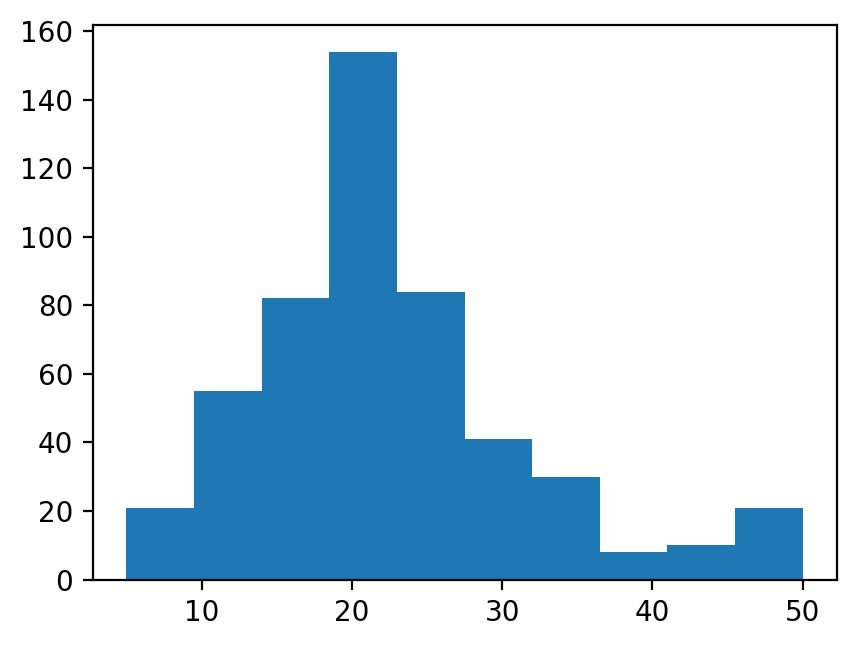

In [45]:
plt.hist(y);

In [46]:
# Разбить выборку на train/valid, вычислить theta,
# сделать предсказания и посчитать ошибки MSE и RMSE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = linreg_linear(X_train, y_train)
y_pred = X_valid.dot(theta)
y_train_pred = X_train.dot(theta)

In [47]:
print_regression_metrics(y_valid, y_pred)
print_regression_metrics(y_train, y_train_pred)

MSE = 19.20, RMSE = 4.38
MSE = 22.80, RMSE = 4.77


In [48]:
from sklearn.linear_model import LinearRegression
:
lr = LinearRegression()
lr.fit(X,y)
y_pred = lr.predict(X)
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


### <b><span style='color:#686dec'>Использованием методов оптимизации (Градиентный Спуск)</span></b>

Для реализации линейной регрессии с помощью методов оптимизации будем использовать функцию ошибки **среднего квадратичного** ([Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)), которая является выпуклой функцией в n-мерном пространстве $\mathbb{R}^n$ и в общем виде выглядит следующим образом:
$$MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - a(x_i))^2}.$$
Здесь $x_i$ — вектор-признак $i$-го объекта обучающей выборки, $y_i$ — истинное значение для $i$-го объекта, $a(x)$ — алгоритм, предсказывающий для данного объекта $x$ целевое значение, $n$ — кол-во объектов в выборке.

В случае линейной регрессии $MSE$ представляется как:
$$MSE(X, y, \theta) = \frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} = \frac{1}{2n} \lVert{y - X\theta}\rVert_{2}^{2}=\frac{1}{2n} (y - X\theta)^T(y - X\theta),$$
где $\theta$ — параметр модели линейной регрессии, $X$ — матрица объекты-признаки, $y$ - вектор истинных значений, соответствующих $X$.

Возьмем первый вариант представления функции ошибки и посчитаем ее градиент по параметру $\theta$, предварительно переименовав $MSE$ в $L$:
$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2}$$
$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} = \frac{1}{n}X^T(X\theta - y)$$

Исходя из полученного выражения градиента, реализуем алгоритм градиентного спуска:

In [49]:
from tqdm.notebook import tqdm

# вычисления градиента функции MSE

def calc_mse_gradient(X, y, theta):
    n = X.shape[0]
    grad = (1.0/n) * X.T.dot(X.dot(theta) - y)
    return grad

# Шаг градиентного спуска  

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad

# Процедура оптимизации

def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    
    # начальное theta
    theta = start_theta.copy()
    
    for i in tqdm(range(n_iters)):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta


In [50]:
# Разбить таблицу данных на матрицы X и y
X, y = data['data'], data['target']

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [51]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.001, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [52]:
theta

array([7.41647399e+246, 3.32349992e+247, 7.39564172e+247, 8.96295209e+247,
       5.07578059e+245, 4.22030567e+246, 4.63094053e+247, 5.29083888e+248,
       2.65643383e+247, 8.19991211e+247, 3.27135991e+249, 1.38363846e+248,
       2.64323053e+249, 9.88835598e+247])

In [53]:
# Проверить максимальные значения по каждому признаку в данных
X.max(axis=0)

array([  1.    ,  88.9762, 100.    ,  27.74  ,   1.    ,   0.871 ,
         8.78  , 100.    ,  12.1265,  24.    , 711.    ,  22.    ,
       396.9   ,  37.97  ])

In [54]:
print(data['feature_names'][np.argmax(X.std(axis=0)) + 1])
print(np.max(X.std(axis=0)))

B
168.3704950393814


In [55]:
# Нормализовать даннные с помощью стандартной нормализации
X, y = data['data'], data['target']
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [56]:
# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:,None], X])
X.max(axis=0)

array([1.        , 9.9339306 , 3.80423444, 2.42256516, 3.66839786,
       2.73234648, 3.55504427, 1.11749449, 3.96051769, 1.66124525,
       1.79819419, 1.63882832, 0.44105193, 3.54877081])

In [57]:
# Оптимизировать theta на новых данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.01, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [58]:
theta

array([ 2.25328063e+01, -9.21740195e-01,  1.07033639e+00,  1.06388396e-01,
        6.86667316e-01, -2.05006416e+00,  2.68062168e+00,  1.40667969e-02,
       -3.10608483e+00,  2.57511475e+00, -1.97802851e+00, -2.05725099e+00,
        8.48690321e-01, -3.74025884e+00])

In [59]:
# Сделать предсказания при полученных параметрах
y_pred = X.dot(theta)

In [60]:
# Посчитать значение ошибок MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

MSE = 21.90, RMSE = 4.68


In [61]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибки MSE и RMSE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_mse_gradient, np.ones(m), 0.01, 5000)
y_pred = X_valid.dot(theta)

print_regression_metrics(y_valid, y_pred)

  0%|          | 0/5000 [00:00<?, ?it/s]

MSE = 20.05, RMSE = 4.48


### <b><span style='color:#686dec'>Задание</span></b>

#### <b>Задание <span style='color:#686dec'>3.6.1</span></b> 


Реализуйте матричную линейную регрессию. Какой получился RMSE?

4.68 (уже выполненно)

#### <b>Задание <span style='color:#686dec'>3.6.2</span></b> 


Постройте модель при помощи sklearn. Используйте параметры по умолчанию, обучите на всей выборке и посчитайте RMSE.

In [62]:
from sklearn.linear_model import LinearRegression as LR

X, y = data['data'], data['target']
X = np.hstack([np.ones(X.shape[0])[:,None], X])

model = LR()
model.fit(X,y)
y_pred = model.predict(X)

print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


#### <b>Задание <span style='color:#686dec'>3.6.3</span></b> 


У какого из признаков наибольшее стандартное отклонение? Чему оно равно?

In [63]:
df = pd.DataFrame(data['data'],columns=data['feature_names'])
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [64]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [65]:
X, y = data['data'], data['target']

print(data.feature_names)
print(X.std(axis=0))

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
[8.59304135e+00 2.32993957e+01 6.85357058e+00 2.53742935e-01
 1.15763115e-01 7.01922514e-01 2.81210326e+01 2.10362836e+00
 8.69865112e+00 1.68370495e+02 2.16280519e+00 9.12046075e+01
 7.13400164e+00]


#### <b>Задание <span style='color:#686dec'>3.6.4</span></b> 


Обучите регрессию без дополнительного столбца единиц. Какой получился RMSE?

In [66]:
X, y = data['data'], data['target']

model = LR()
model.fit(X,y)
y_pred = model.predict(X)

print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


#### <b>Задание <span style='color:#686dec'>3.6.5</span></b> 


Очистите данные от строк, где значение признака  меньше . Какой получился RMSE?

In [67]:
df = pd.DataFrame(data['data'],columns=data['feature_names'])
dfy = pd.DataFrame(data['target'],columns=['target'])
df_all = pd.concat([df,dfy],axis=1)

ldf = df_all[~(df_all['B'] < 50)]
ldf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [68]:
y = ldf['target']
X = ldf.drop(['target'],axis=1)

X = np.hstack([np.ones(X.shape[0])[:,None], X])

model = LR()
model.fit(X,y)
y_pred = model.predict(X)

print_regression_metrics(y, y_pred)

MSE = 21.79, RMSE = 4.67


#### <b>Задание <span style='color:#686dec'>3.6.6</span></b> 


Нормализуйте признаки и обучите линейную регрессию матричным методом. Какой получился RMSE?

In [70]:
# Разбить таблицу данных на матрицы X и y
X, y = data['data'], data['target']
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

In [73]:
def linreg_linear(X, y):
    lsm = inv(np.dot(X.T,X))
    Xt = np.dot(X.T,y)
    theta = np.dot(lsm,Xt)
    return theta

theta = linreg_linear(X,y)
y_pred = X.dot(theta)

print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68
